<a href="https://colab.research.google.com/github/paggyhaggns/software-training/blob/main/hw4_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

change to whatever your path is to homework4 folder

In [ ]:
%cd "drive/MyDrive/Fall 2024/CS 7643/hw4_code_student_version/part1-GANs"

In [ ]:

%load_ext autoreload
%autoreload 2

# Homework 4: Part 1 - Generative Adversarial Networks (GANs) [9 pts]

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short).

In a GAN, there are two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$) and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will alternate between taking gradient *descent* steps on the objective for $G$ and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__.
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661).

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

In [ ]:
# Setup cell.
import numpy as np
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dataset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import sys
sys.path.append("part1-GANS")

from gan_pytorch import preprocess_img, deprocess_img, rel_error, count_params, ChunkSampler

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        # If the image is in the shape (3, 32, 32), use transpose to change it to (32, 32, 3).
        if img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))
        plt.imshow(img)
        # plt.show()

    return

## Dataset

We are going to be using SVHN (Street View and House Number Dataset)

Link: http://ufldl.stanford.edu/housenumbers/

<!-- ![Dataset Representation](images/svhn_data_sample.png) -->
<!--
<img src = "../assets/svhn_data_sample.png"> -->

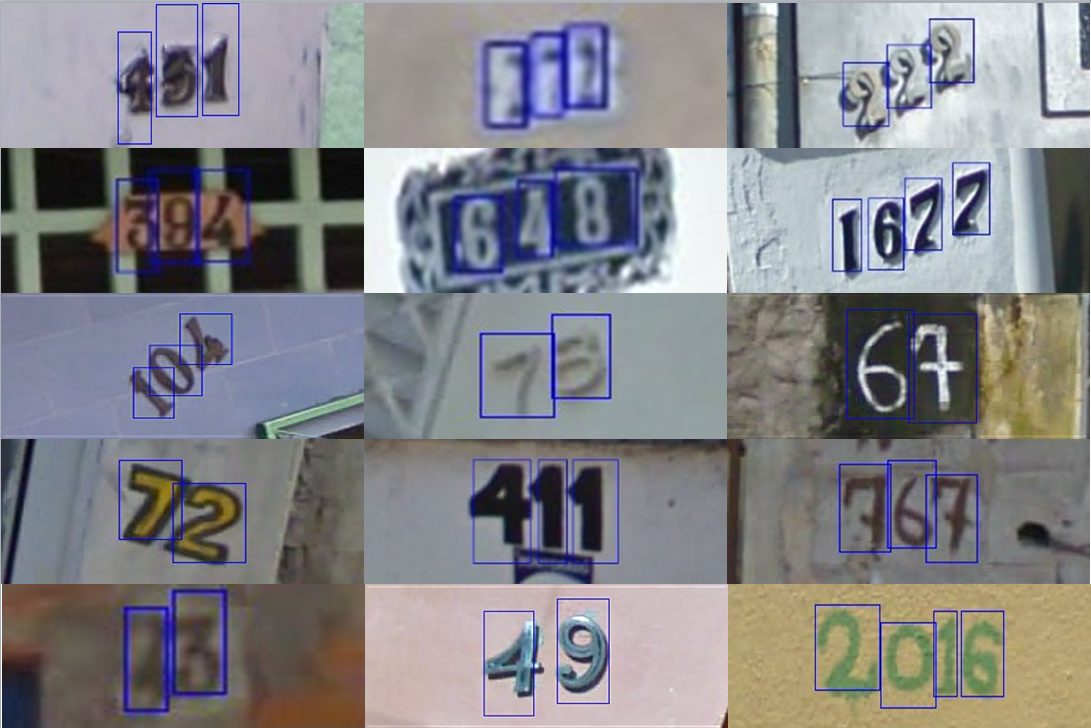

Using downloaded and verified file: datasets/svhn/train_32x32.mat
73257
Using downloaded and verified file: datasets/svhn/test_32x32.mat
26032


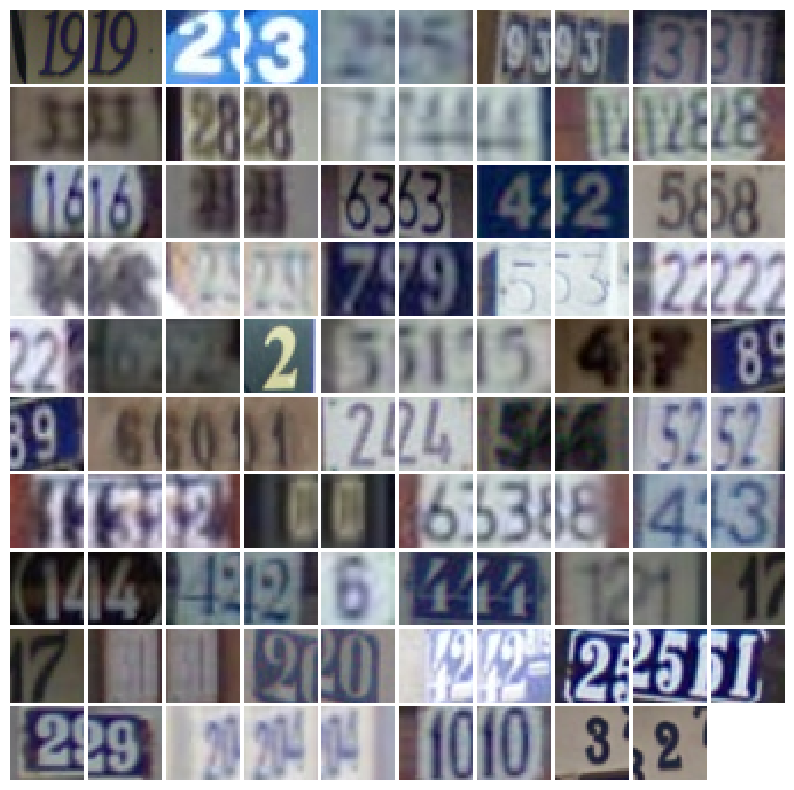

In [ ]:
# NUM_TRAIN = 73257
# NUM_VAL = 26032

NOISE_DIM = 96
batch_size = 128
val_batch_size = 128

svhn_train = dataset.SVHN(
    'datasets/svhn',
    split="train",
    download=True,
    transform=T.ToTensor()
)
loader_train = DataLoader(
    svhn_train,
    batch_size=batch_size,
    sampler=ChunkSampler(len(svhn_train), 0)
)

print(len(svhn_train))

svhn_val = dataset.SVHN(
    'datasets/svhn',
    split="test",
    download=True,
    transform=T.ToTensor()
)

print(len(svhn_val))

loader_val = DataLoader(
    svhn_val,
    batch_size=val_batch_size,
    sampler=ChunkSampler(len(svhn_val), 0)
)

iterator = iter(loader_train)
imgs, labels = next(iterator)
# print(imgs.shape)
# imgs = imgs.view(batch_size, 3072).numpy().squeeze()
show_images(imgs[0:99])

## TODO: Random Noise [1pts]

Generate uniform noise from -1 to 1 with shape `[batch_size, dim]`.

Implement `sample_noise` in `gan_pytorch.py`.

Hint: use `torch.rand`.

Make sure noise is the correct shape and type:

Note: If you get error about tensors not being on same device, make sure that all your tensors are on the same device using `.type(dtype)`

In [ ]:
from gan_pytorch import sample_noise
from gan_pytorch import Flatten, Unflatten, initialize_weights

def test_sample_noise():
    batch_size = 3
    dim = 4
    torch.manual_seed(6476)
    z = sample_noise(batch_size, dim)
    np_z = z.cpu().numpy()
    assert np_z.shape == (batch_size, dim)
    assert torch.is_tensor(z)
    assert np.all(np_z >= -1.0) and np.all(np_z <= 1.0)
    assert np.any(np_z < 0.0) and np.any(np_z > 0.0)
    print('All tests passed!')

test_sample_noise()

All tests passed!


# TODO: Discriminator [0.5 pts]

GAN is composed of a discriminator and generator. The discriminator differentiates between a real and fake image. Let us create the architecture for it. In `gan_pytorch.py`, fill in the architecture as part of the `nn.Sequential` constructor in the function below. All fully connected layers should include bias terms.

The recommendation for discriminator architecture is to have 1-2 Conv2D blocks, and a fully connected layer after that. It is also recommended to include batch normalization as well.

Recall that the Leaky ReLU nonlinearity computes $f(x) = \max(\alpha x, x)$ for some fixed constant $\alpha$; for the LeakyReLU nonlinearities in the architecture above we set $\alpha=0.01$.

The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [ ]:
from gan_pytorch import discriminator

def test_discriminator():
    model = discriminator()
    cur_count = count_params(model)
    print('Number of parameters in discriminator: ', cur_count)

test_discriminator()

Number of parameters in discriminator:  2307841


## TODO: Generator [0.5 pts]

Recommendation for the generator is to have some fully connected layer followed by 1-2 ConvTranspose2D (It is also known as a fractionally-strided convolution). It is recommended to include batch normalization as well. Remember to use activation functions such as ReLU, Leaky RelU, etc. Finally use nn.Tanh() to finally output between [-1, 1].

The output of a generator should be the image. Therefore the shape will be `[batch_size, 3, 32, 32]`.

In [ ]:
from gan_pytorch import generator

def test_generator():
    model = generator()
    cur_count = count_params(model)
    print('Number of parameters in generator: ', cur_count)

test_generator()

Number of parameters in generator:  8648899


## TODO: Implement the Discriminator and Generator Loss Function [3 pts]

This will be the Vanilla GAN loss function which involves the Binary Cross Entropy Loss. Fill the ```bce_loss```, ```discriminator_loss```, and ```generator_loss```. The errors should be less than 5e-5.

Hint: Use Pytorch's `nn.functional.binary_cross_entropy_with_logits()` when implementing `bce_loss()`

Note: `binary_cross_entropy_with_logits()` already contains a Sigmoid layer so issues may arise later if you already have it in your discriminator architecture

In [ ]:
from gan_pytorch import bce_loss, discriminator_loss, generator_loss

answers = dict(np.load('../test_resources/gan-checks.npz'))

def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(torch.Tensor(logits_real).type(dtype),
                                torch.Tensor(logits_fake).type(dtype)).cpu()
    assert torch.allclose(torch.Tensor(d_loss_true), torch.Tensor(d_loss), rtol=1e-05, atol=1e-08, equal_nan=False)
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss.numpy()))

def test_generator_loss():
    sample_logits = torch.tensor([0.0, 0.5, 0.4, 0.1])
    g_loss = generator_loss(torch.Tensor(sample_logits).type(dtype)).cpu().numpy()
    assert torch.allclose(torch.Tensor([0.581159]), torch.Tensor(g_loss), rtol=1e-05, atol=1e-08, equal_nan=False)
    print("Maximum error in d_loss: %g"%rel_error(0.581159, g_loss.item()))

def test_bce_loss():
    input = torch.tensor([0.4, 0.1, 0.2, 0.3])
    target = torch.tensor([0.3, 0.25, 0.25, 0.2])
    bc_loss = bce_loss(input, target).item()
    assert torch.allclose(torch.Tensor([0.7637264728546143]), torch.Tensor([bc_loss]), rtol=1e-04, atol=1e-08, equal_nan=False)
    print("Maximum error in d_loss: %g"%rel_error(0.7637264728546143, bc_loss))

test_discriminator_loss(
    answers['logits_real'],
    answers['logits_fake'],
    answers['d_loss_true']
)

test_generator_loss()

test_bce_loss()

Maximum error in d_loss: 3.97058e-09
Maximum error in d_loss: 3.76114e-09
Maximum error in d_loss: 0


## Now let's complete the GAN

Fill the training function `train_gan` and make sure to complete the `get_optimizer`. Adam is a good recommendation for the optimizer.

The top batch of images shown are the outputs from your generator.  The bottom batch of images are the real inputs that the discriminator recieves along with your generated images.

Note: Make sure to detach the tensors that track gradients using `.detach()` if you get in-place modification errors

In [ ]:
from gan_pytorch import get_optimizer, train_gan

# Make the discriminator
D = discriminator().type(dtype)

# Make the generator
G = generator().type(dtype)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)

batch_size = 256

loader_train = DataLoader(
    svhn_train,
    batch_size=batch_size,
    sampler=ChunkSampler(len(svhn_train), 0)
)

# Run it!
images = train_gan(
    D,
    G,
    D_solver,
    G_solver,
    discriminator_loss,
    generator_loss,
    loader_train,
    batch_size = batch_size,
    noise_size=96,
    num_epochs=30
)

### You do not have to save the above training images for your final report, please just save the images generated by the cell below

Iter: 0


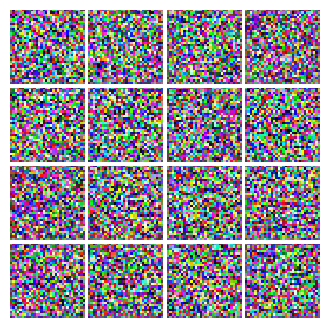

Iter: 4000


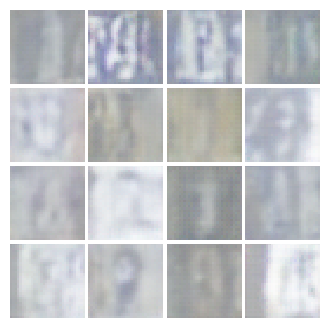

Iter: 8000


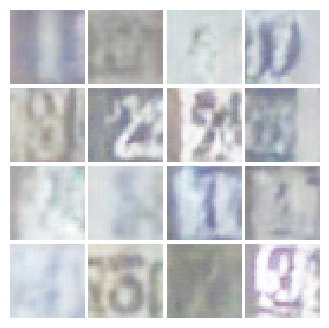

Iter: 12000


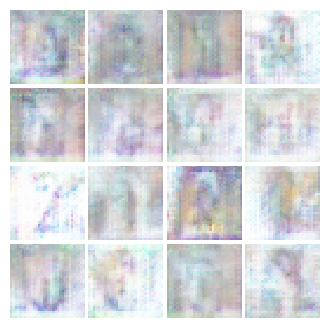

Iter: 16000


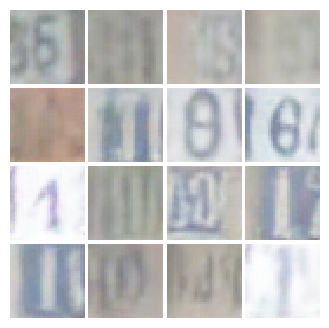

Iter: 20000


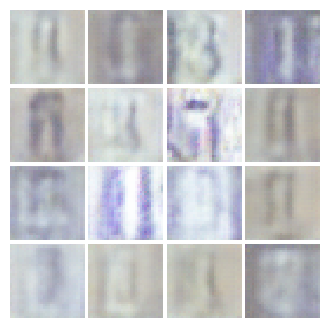

Iter: 24000


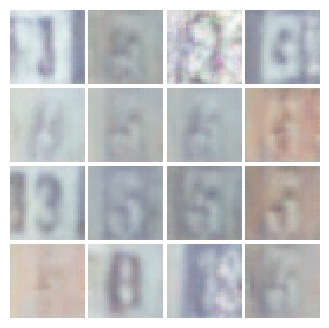

Iter: 28000


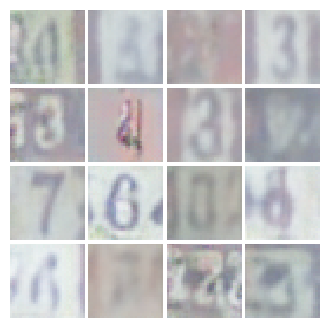

Iter: 32000


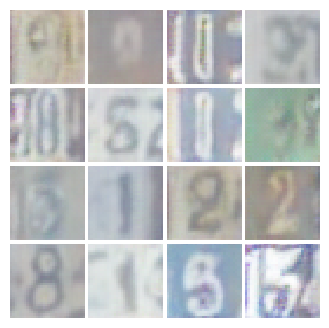

In [ ]:
numIter = 0
if len(images) > 8:
    step = len(images) // 8
else:
    step = 1

for i in range(0, len(images), step):
    img = images[i]
    numIter = 250 * i * step
    print("Iter: {}".format(numIter))
    img = (img)/2 + 0.5
    show_images(img.reshape(-1, 3, 32, 32))
    plt.show()


## [TODO] GAN Output Visual Evaluation [2pts (Report)]
The main deliverable for this notebook is the final GAN generations!  Run the cells in this section to show your final output.  If you are unhappy with the generation, feel free to train for longer.  Keep in mind we are not expecting perfect outputs, especially considering your limited computation resources.  Below we have shown a few example images of what acceptable and unacceptable outputs are.  Make sure your final image displays and is included in the report. Common problems with GANs are listed below in the following resources and can help you get a better understanding as to why you GAN maybe producing an unreasonable output.

Website: https://developers.google.com/machine-learning/gan/problems

Website: https://medium.com/@miraytopal/what-is-mode-collapse-in-gans-d3428a7bd9b8

\
\
Acceptable Output:

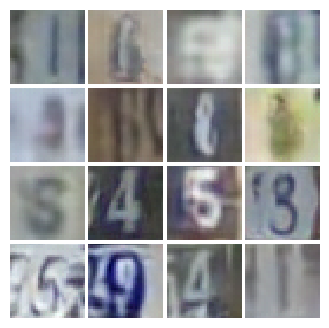

Unreasonable Output:


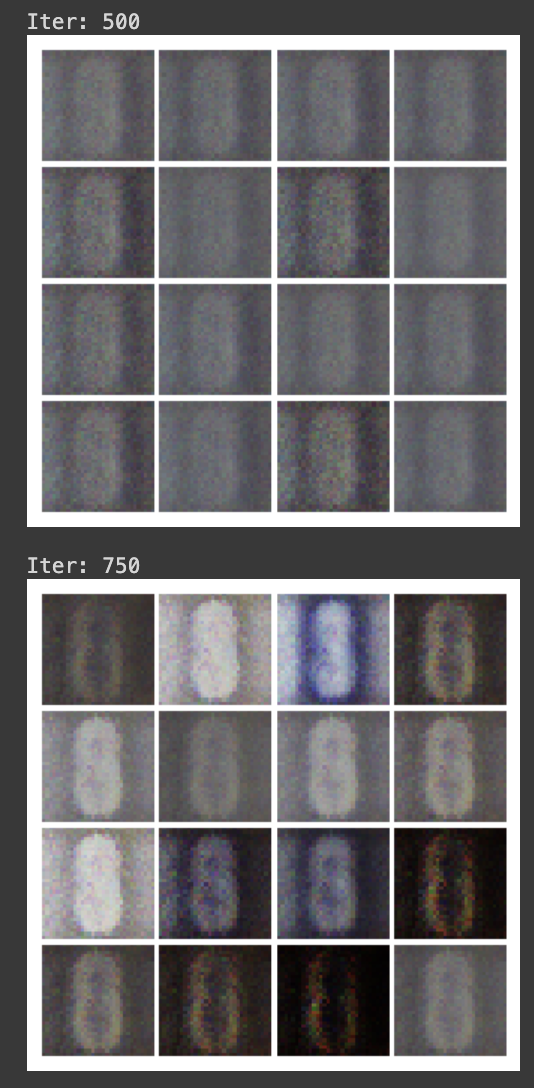

Vanilla GAN final image:


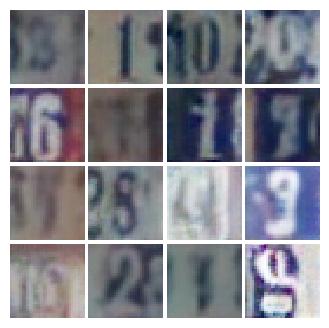

In [ ]:
# This output is your answer - please include in the final report
print("Vanilla GAN final image:")
fin = (images[-1] - images[-1].min()) / (images[-1].max() - images[-1].min())
show_images(fin.reshape(-1, 3, 32, 32))
plt.show()

# Reflections (2 Points)

## [TODO]: Reflect on the GAN Training Process. What were some of the difficulties? How good were the generated outputs?

One of the biggest difficulties for Training GANs is simply the time and resources it took. Even using a GPU trainnig this model took much longer than anyhting else in this class for me. As for issues coding it was odd having fundementally different model archtectures for the Generator and Discriminator.

Overall I would say the generated outputs are passable, if just glancing at them(especially at a distance) it is easy to mistake them for real numbers. Additionally, out of the 16 images I would say 3/4 look completly real, just shot with a bad camera. Of the remaining images 2 are complete nonsense, while it is text on a background it does not seem like numbers instead being closer to a leter or symbols.

## [TODO] What is a mode collapse in GAN training, can you find any examples in your training?

A mode collapse is when the generator does not capture the uniqueness of the input/training data. This results in the generators output being just a few images regardless of the input. In other words it "collapses" into a few outputs and disregards all others. This can happen for a bunch of reasons, for example if the discriminator is to overpowering the generator will not explore much of the distrobution. I did not see anything catastrophic, but I definitely noticed there were some images/scenes that were very very similar among a couple of generations. That beng said I did not see a complete mode colapse with just the same few images being created.


## [TODO] Talk about the trends that you see in the losses for the generator and the discriminator.  Explain why those values might make sense given the quality of the images generated after a given number of itterations.

At fisrt both the Descriminator(D) and Generator(G) have a relatively high loss. This makes sense as both have no information yet, they are just starting to learn so both will be not the best. However, as we move on both of the losses start to drop, in my case G dropped much faster as it only takes a slight improvement to make it much much harder for the D. At this point the two seemed to get in a game of cat an mouse as the losses oscillated a bit. It seems like as one gets better the other is forced to improve, so their loses spend some time going up and down. This makes sense to me as G improves D will fall behind a bit before becoming better forcing G to then improve. Near the end of our training it seems like the oscillations started to slow down as the loses converged to their final answers. I would imagine had we let this train for even longer the two would reach the point of Nash Equilibrium and the losses would change very little iteration to iteration.

## Saving Models

In [ ]:
# You must save these models to run the next cells
torch.save(D.state_dict(), "d_smart.pth")
torch.save(G.state_dict(), "g_smart.pth")

# Evaluating GANS

## Evaluating via FID Score

It is hard to evaluate GANs effectiveness quantiatively. One way we can do this is by calculating FID (Frechet-Inception-Distance).

<!-- Read more about what it is and implement it. Two function headers are provided for you: `calculate_inception_features` and `calculate_fid`.

`calculate_inception_features`: This function is to get the features by running Inception v3

`calculate_fid`: This function uses the real and fake features to calculate the FID score -->

Website: https://wandb.ai/ayush-thakur/gan-evaluation/reports/How-to-Evaluate-GANs-using-Frechet-Inception-Distance-FID---Vmlldzo0MTAxOTI

But for this assignment, we will visually evaluate the GAN outputs.

## TODO: Evaluating Discriminator

*Not graded* but for fun see how well your discriminator does against a sample generator.

In [ ]:
from gan_pytorch import get_optimizer, eval_gan, eval_discriminator
from gan_pytorch import generator, discriminator, discriminator_loss, generator_loss

D = discriminator().type(dtype)
D.load_state_dict(torch.load("d_smart.pth"))
D.eval()

oracle_g = torch.jit.load("../test_resources/g_smart_o.pt")
oracle_g.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

accuracy, p, r = eval_discriminator(D, oracle_g, loader_val, device)

# Test accuracy is greater than 0.55
assert accuracy > 0.55


## Preparing for Submission

Run the following cell to collect ```hw4_submission_part1.zip```.  You will submit this to HW4: Part 2 - GANs on gradescope.  Make sure to also export a PDF of this jupyter notebook and attach that to the end of your theory section.  This PDF must show your answers to all the questions in the document, please include the final photos that you generate as well.  Do not include all of your training images!  You will not be given credit for anything that is not visible to us in this PDF.

In [ ]:
!sh collect_submission_part1.sh

updating: gan_pytorch.py (deflated 77%)


*Contributers*
- Manav Agrawal (Lead)
- Matthew Bronars
- Mihir Bafna